In [46]:
import os
import logging
import torch
import numpy as np
import copy
import os.path
import sys
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset
from PIL import Image
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib as mlp
from tqdm import tqdm
from torch.autograd import Variable
import pandas as pd
from itertools import cycle
import seaborn as sns
import import_ipynb
from MODELLO import resnet32
from seed import seed
sns.set()

In [77]:
class FineTuning(nn.Module):
    def __init__(self, n_classes, dictionary):

        super(FineTuning, self).__init__()

        self.model = resnet32()
        self.prev_model = None
        self.criterion = nn.BCEWithLogitsLoss()
        self.num_classes = n_classes
        self.bs = 10
        self.num_epochs = 70
        self.dictionary = dictionary

    def forward(self,x):
        x = self.model(x) 
        return x


    def train_model(self, dataloader):
        loss_array = []
        self.model = self.model.cuda()
        cudnn.benchmark
        
        start = time.time()
        
        optimizer = optim.SGD(self.model.parameters(), lr=2, momentum=0.9, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [49,63], gamma=0.2)

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch+1, self.num_epochs))
            print('-' * 10)

            self.model.train() 

            running_loss = 0.0
            running_corrects = 0
            current_step = 0
            for images, labels in dataloader:

                labels_map = [self.dictionary[label.item()] for label in labels]
                
                labels_map = torch.as_tensor(labels_map)
                
                images = images.cuda()
                labels_map = labels_map.cuda()
                
                optimizer.zero_grad()
                
                outputs = self.model(images)
                one_hot = nn.functional.one_hot(labels_map, self.num_classes)
                
                one_hot = one_hot.type_as(outputs)       
                _, preds = torch.max(outputs.data, 1)
                
                loss = self.criterion(outputs, one_hot)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels_map.data).data.item()
                current_step+=1

            del images, labels
            torch.cuda.empty_cache()

            epoch_loss = running_loss / float(len(dataloader.dataset))
            epoch_acc = running_corrects/ float(len(dataloader.dataset))
            loss_array.append(epoch_loss)
            scheduler.step()

            print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
            print()

        time_elapsed = time.time() - start

        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


    def test_model(self, dataloader):
        self.model = self.model.cuda()
        self.model.train(False)
        running_corrects = 0
        current_step = 0

        corrects = []
        predictions = []
        for images, labels in tqdm(dataloader):

            labels_map = [self.dictionary[label.item()] for label in labels]

            labels_map = torch.as_tensor(labels_map)
            images = images.cuda()
            labels_map = labels_map.cuda()     
            outputs = self.model(images)
            _, preds = torch.max(outputs.data, 1)
            running_corrects += torch.sum(preds == labels_map.data).data.item()
            for lab,pred in zip(labels_map, preds):
                corrects.append(lab.item())
                predictions.append(pred.item())

            current_step+=1

        accuracy = running_corrects / float(len(dataloader.dataset))
        print('Test Accuracy: {}'.format(accuracy))
        confmat = confusion_matrix(corrects, predictions)
        self.print_confusion_matrix(confmat, set(corrects))
        torch.cuda.empty_cache()
        plt.show()
        return accuracy

    def update_model(self):
        self.prev_model = copy.deepcopy(self.model)
        self.model.fc = nn.Linear(64, self.num_classes+self.bs)  
        self.model.fc.weight.data[0: self.num_classes] = self.prev_model.fc.weight.data
        self.model.fc.bias.data[0: self.num_classes] = self.prev_model.fc.bias.data

    
    def print_confusion_matrix(self,confusion_matrix, class_names):

        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
        fig = plt.figure(figsize=(6,4))
        try:
            cmap = plt.get_cmap('jet')
            new_cmap = self.truncate_colormap(cmap, 0.05, 0.85)
            heatmap = sns.heatmap(df_cm, annot=False, fmt="d", cmap = new_cmap)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=5)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=5)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        return fig


    def truncate_colormap(self,cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = mlp.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap


In [28]:
import random 
train_transform=transforms.Compose([
            transforms.RandomCrop(32, padding = 4),
            transforms.RandomHorizontalFlip(p=0.5),           
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [39]:
#generating random indices
samples = seed

#dictionary for mapping the classes
d = {samples[i]:i for i in range(len(samples))}

#creating the batches of data for different groups of 10 classes
batches_train = []
batches_test = []

for i in range(10,110,10):
  x = samples[i-10:i]
  y = samples[0:i]
  idx_train = [i for i,el in enumerate(trainset.targets) if el in x]
  batches_train.append(Subset(trainset,idx_train))
  idx_test = [j for j, el in enumerate(testset.targets) if el in y]
  batches_test.append(Subset(testset, idx_test))


train_dataloaders = [DataLoader(batch, batch_size=128, shuffle=False, num_workers=4) for batch in batches_train]
test_dataloaders = [DataLoader(batch, batch_size=128, shuffle=True, num_workers=4) for batch in batches_test]


step: 0 classes: 10

Epoch 1/70
----------
Loss: 0.4016 Acc: 0.1292

Epoch 2/70
----------
Loss: 0.3157 Acc: 0.1570

Epoch 3/70
----------
Loss: 0.3126 Acc: 0.1682

Epoch 4/70
----------
Loss: 0.3133 Acc: 0.1662

Epoch 5/70
----------
Loss: 0.3117 Acc: 0.1710

Epoch 6/70
----------
Loss: 0.3106 Acc: 0.1720

Epoch 7/70
----------
Loss: 0.3098 Acc: 0.1756

Epoch 8/70
----------
Loss: 0.3087 Acc: 0.1782

Epoch 9/70
----------
Loss: 0.3050 Acc: 0.2088

Epoch 10/70
----------
Loss: 0.2954 Acc: 0.2516

Epoch 11/70
----------
Loss: 0.2877 Acc: 0.2950

Epoch 12/70
----------
Loss: 0.2837 Acc: 0.3070

Epoch 13/70
----------
Loss: 0.2792 Acc: 0.3184

Epoch 14/70
----------
Loss: 0.2713 Acc: 0.3464

Epoch 15/70
----------
Loss: 0.2664 Acc: 0.3622

Epoch 16/70
----------
Loss: 0.2619 Acc: 0.3766

Epoch 17/70
----------
Loss: 0.2586 Acc: 0.3872

Epoch 18/70
----------
Loss: 0.2513 Acc: 0.3996

Epoch 19/70
----------
Loss: 0.2458 Acc: 0.4278

Epoch 20/70
----------
Loss: 0.2444 Acc: 0.4352

Epoch 21

  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.0307 Acc: 0.9542

Training complete in 6m 15s


100%|██████████| 8/8 [00:00<00:00, 11.61it/s]


Test Accuracy: 0.757


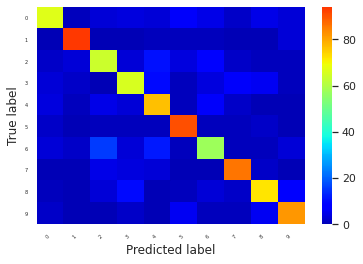

step: 1 classes: 20

Epoch 1/70
----------
Loss: 0.1704 Acc: 0.2884

Epoch 2/70
----------
Loss: 0.1075 Acc: 0.5314

Epoch 3/70
----------
Loss: 0.0932 Acc: 0.6054

Epoch 4/70
----------
Loss: 0.0813 Acc: 0.6612

Epoch 5/70
----------
Loss: 0.0743 Acc: 0.6966

Epoch 6/70
----------
Loss: 0.0672 Acc: 0.7278

Epoch 7/70
----------
Loss: 0.0624 Acc: 0.7484

Epoch 8/70
----------
Loss: 0.0566 Acc: 0.7776

Epoch 9/70
----------
Loss: 0.0540 Acc: 0.7936

Epoch 10/70
----------
Loss: 0.0497 Acc: 0.8136

Epoch 11/70
----------
Loss: 0.0478 Acc: 0.8158

Epoch 12/70
----------
Loss: 0.0457 Acc: 0.8232

Epoch 13/70
----------
Loss: 0.0439 Acc: 0.8328

Epoch 14/70
----------
Loss: 0.0399 Acc: 0.8506

Epoch 15/70
----------
Loss: 0.0382 Acc: 0.8566

Epoch 16/70
----------
Loss: 0.0382 Acc: 0.8578

Epoch 17/70
----------
Loss: 0.0360 Acc: 0.8658

Epoch 18/70
----------
Loss: 0.0317 Acc: 0.8820

Epoch 19/70
----------
Loss: 0.0357 Acc: 0.8674

Epoch 20/70
----------
Loss: 0.0322 Acc: 0.8798

Epoch 21

  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 0.0010 Acc: 0.9988

Training complete in 6m 14s


100%|██████████| 16/16 [00:01<00:00, 14.52it/s]


Test Accuracy: 0.431


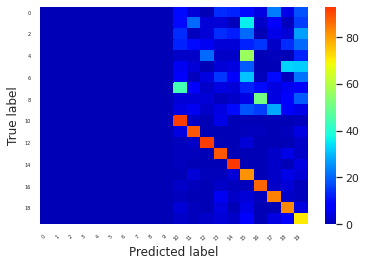

step: 2 classes: 30

Epoch 1/70
----------
Loss: 0.1184 Acc: 0.2936

Epoch 2/70
----------
Loss: 0.0650 Acc: 0.5528

Epoch 3/70
----------
Loss: 0.0543 Acc: 0.6416

Epoch 4/70
----------
Loss: 0.0471 Acc: 0.6978

Epoch 5/70
----------
Loss: 0.0428 Acc: 0.7330

Epoch 6/70
----------
Loss: 0.0384 Acc: 0.7624

Epoch 7/70
----------
Loss: 0.0345 Acc: 0.7944

Epoch 8/70
----------
Loss: 0.0336 Acc: 0.7956

Epoch 9/70
----------
Loss: 0.0303 Acc: 0.8224

Epoch 10/70
----------
Loss: 0.0280 Acc: 0.8368

Epoch 11/70
----------
Loss: 0.0259 Acc: 0.8476

Epoch 12/70
----------
Loss: 0.0253 Acc: 0.8512

Epoch 13/70
----------
Loss: 0.0257 Acc: 0.8500

Epoch 14/70
----------
Loss: 0.0219 Acc: 0.8736

Epoch 15/70
----------
Loss: 0.0209 Acc: 0.8810

Epoch 16/70
----------
Loss: 0.0201 Acc: 0.8796

Epoch 17/70
----------
Loss: 0.0202 Acc: 0.8870

Epoch 18/70
----------
Loss: 0.0198 Acc: 0.8810

Epoch 19/70
----------
Loss: 0.0197 Acc: 0.8870

Epoch 20/70
----------
Loss: 0.0189 Acc: 0.8968

Epoch 21

  0%|          | 0/24 [00:00<?, ?it/s]

Loss: 0.0009 Acc: 0.9988

Training complete in 6m 15s


100%|██████████| 24/24 [00:01<00:00, 15.88it/s]


Test Accuracy: 0.281


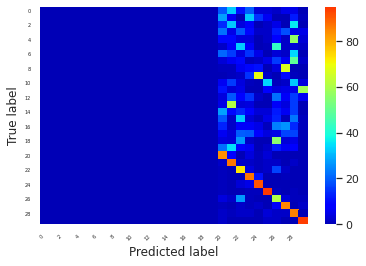

step: 3 classes: 40

Epoch 1/70
----------
Loss: 0.0859 Acc: 0.3210

Epoch 2/70
----------
Loss: 0.0441 Acc: 0.6296

Epoch 3/70
----------
Loss: 0.0340 Acc: 0.7318

Epoch 4/70
----------
Loss: 0.0271 Acc: 0.8002

Epoch 5/70
----------
Loss: 0.0243 Acc: 0.8222

Epoch 6/70
----------
Loss: 0.0211 Acc: 0.8452

Epoch 7/70
----------
Loss: 0.0189 Acc: 0.8656

Epoch 8/70
----------
Loss: 0.0168 Acc: 0.8794

Epoch 9/70
----------
Loss: 0.0149 Acc: 0.8960

Epoch 10/70
----------
Loss: 0.0152 Acc: 0.8912

Epoch 11/70
----------
Loss: 0.0140 Acc: 0.9022

Epoch 12/70
----------
Loss: 0.0137 Acc: 0.9048

Epoch 13/70
----------
Loss: 0.0146 Acc: 0.8992

Epoch 14/70
----------
Loss: 0.0114 Acc: 0.9216

Epoch 15/70
----------
Loss: 0.0125 Acc: 0.9142

Epoch 16/70
----------
Loss: 0.0107 Acc: 0.9268

Epoch 17/70
----------
Loss: 0.0092 Acc: 0.9364

Epoch 18/70
----------
Loss: 0.0082 Acc: 0.9442

Epoch 19/70
----------
Loss: 0.0079 Acc: 0.9502

Epoch 20/70
----------
Loss: 0.0068 Acc: 0.9552

Epoch 21

  0%|          | 0/32 [00:00<?, ?it/s]

Loss: 0.0004 Acc: 0.9998

Training complete in 6m 16s


100%|██████████| 32/32 [00:01<00:00, 16.76it/s]


Test Accuracy: 0.21925


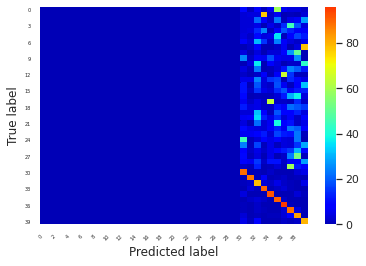

step: 4 classes: 50

Epoch 1/70
----------
Loss: 0.0689 Acc: 0.3574

Epoch 2/70
----------
Loss: 0.0303 Acc: 0.6774

Epoch 3/70
----------
Loss: 0.0235 Acc: 0.7662

Epoch 4/70
----------
Loss: 0.0199 Acc: 0.8108

Epoch 5/70
----------
Loss: 0.0172 Acc: 0.8392

Epoch 6/70
----------
Loss: 0.0153 Acc: 0.8530

Epoch 7/70
----------
Loss: 0.0139 Acc: 0.8724

Epoch 8/70
----------
Loss: 0.0133 Acc: 0.8730

Epoch 9/70
----------
Loss: 0.0119 Acc: 0.8896

Epoch 10/70
----------
Loss: 0.0113 Acc: 0.8978

Epoch 11/70
----------
Loss: 0.0107 Acc: 0.9032

Epoch 12/70
----------
Loss: 0.0102 Acc: 0.9076

Epoch 13/70
----------
Loss: 0.0097 Acc: 0.9064

Epoch 14/70
----------
Loss: 0.0094 Acc: 0.9186

Epoch 15/70
----------
Loss: 0.0088 Acc: 0.9152

Epoch 16/70
----------
Loss: 0.0085 Acc: 0.9268

Epoch 17/70
----------
Loss: 0.0080 Acc: 0.9298

Epoch 18/70
----------
Loss: 0.0076 Acc: 0.9346

Epoch 19/70
----------
Loss: 0.0072 Acc: 0.9380

Epoch 20/70
----------
Loss: 0.0067 Acc: 0.9422

Epoch 21

  0%|          | 0/40 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9994

Training complete in 6m 15s


100%|██████████| 40/40 [00:02<00:00, 17.57it/s]


Test Accuracy: 0.1766


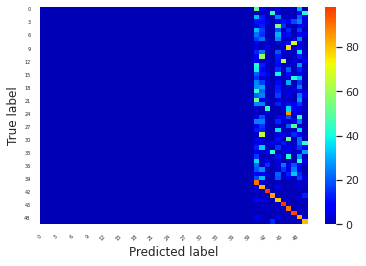

step: 5 classes: 60

Epoch 1/70
----------
Loss: 0.0629 Acc: 0.2806

Epoch 2/70
----------
Loss: 0.0312 Acc: 0.6146

Epoch 3/70
----------
Loss: 0.0245 Acc: 0.7154

Epoch 4/70
----------
Loss: 0.0198 Acc: 0.7782

Epoch 5/70
----------
Loss: 0.0169 Acc: 0.8096

Epoch 6/70
----------
Loss: 0.0170 Acc: 0.8122

Epoch 7/70
----------
Loss: 0.0134 Acc: 0.8528

Epoch 8/70
----------
Loss: 0.0125 Acc: 0.8606

Epoch 9/70
----------
Loss: 0.0111 Acc: 0.8824

Epoch 10/70
----------
Loss: 0.0106 Acc: 0.8858

Epoch 11/70
----------
Loss: 0.0098 Acc: 0.8962

Epoch 12/70
----------
Loss: 0.0101 Acc: 0.8930

Epoch 13/70
----------
Loss: 0.0085 Acc: 0.9098

Epoch 14/70
----------
Loss: 0.0082 Acc: 0.9138

Epoch 15/70
----------
Loss: 0.0079 Acc: 0.9190

Epoch 16/70
----------
Loss: 0.0074 Acc: 0.9246

Epoch 17/70
----------
Loss: 0.0064 Acc: 0.9324

Epoch 18/70
----------
Loss: 0.0069 Acc: 0.9306

Epoch 19/70
----------
Loss: 0.0064 Acc: 0.9326

Epoch 20/70
----------
Loss: 0.0071 Acc: 0.9284

Epoch 21

  0%|          | 0/47 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9996

Training complete in 6m 16s


100%|██████████| 47/47 [00:02<00:00, 17.34it/s]


Test Accuracy: 0.14833333333333334


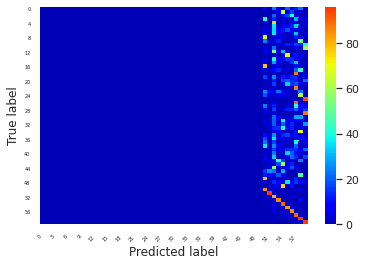

step: 6 classes: 70

Epoch 1/70
----------
Loss: 0.0490 Acc: 0.3354

Epoch 2/70
----------
Loss: 0.0251 Acc: 0.6228

Epoch 3/70
----------
Loss: 0.0207 Acc: 0.7036

Epoch 4/70
----------
Loss: 0.0183 Acc: 0.7362

Epoch 5/70
----------
Loss: 0.0161 Acc: 0.7824

Epoch 6/70
----------
Loss: 0.0142 Acc: 0.7992

Epoch 7/70
----------
Loss: 0.0134 Acc: 0.8194

Epoch 8/70
----------
Loss: 0.0126 Acc: 0.8280

Epoch 9/70
----------
Loss: 0.0112 Acc: 0.8454

Epoch 10/70
----------
Loss: 0.0106 Acc: 0.8574

Epoch 11/70
----------
Loss: 0.0101 Acc: 0.8636

Epoch 12/70
----------
Loss: 0.0099 Acc: 0.8690

Epoch 13/70
----------
Loss: 0.0091 Acc: 0.8820

Epoch 14/70
----------
Loss: 0.0082 Acc: 0.8952

Epoch 15/70
----------
Loss: 0.0082 Acc: 0.8982

Epoch 16/70
----------
Loss: 0.0084 Acc: 0.8944

Epoch 17/70
----------
Loss: 0.0082 Acc: 0.8936

Epoch 18/70
----------
Loss: 0.0072 Acc: 0.9098

Epoch 19/70
----------
Loss: 0.0066 Acc: 0.9164

Epoch 20/70
----------
Loss: 0.0070 Acc: 0.9112

Epoch 21

  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9998

Training complete in 6m 14s


100%|██████████| 55/55 [00:03<00:00, 18.11it/s]


Test Accuracy: 0.12557142857142858


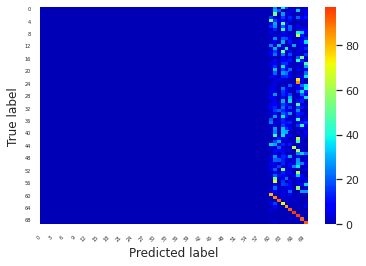

step: 7 classes: 80

Epoch 1/70
----------
Loss: 0.0451 Acc: 0.3046

Epoch 2/70
----------
Loss: 0.0236 Acc: 0.5714

Epoch 3/70
----------
Loss: 0.0190 Acc: 0.6754

Epoch 4/70
----------
Loss: 0.0160 Acc: 0.7334

Epoch 5/70
----------
Loss: 0.0135 Acc: 0.7860

Epoch 6/70
----------
Loss: 0.0123 Acc: 0.8134

Epoch 7/70
----------
Loss: 0.0111 Acc: 0.8282

Epoch 8/70
----------
Loss: 0.0102 Acc: 0.8458

Epoch 9/70
----------
Loss: 0.0090 Acc: 0.8662

Epoch 10/70
----------
Loss: 0.0113 Acc: 0.8244

Epoch 11/70
----------
Loss: 0.0091 Acc: 0.8642

Epoch 12/70
----------
Loss: 0.0078 Acc: 0.8874

Epoch 13/70
----------
Loss: 0.0073 Acc: 0.8936

Epoch 14/70
----------
Loss: 0.0070 Acc: 0.8978

Epoch 15/70
----------
Loss: 0.0059 Acc: 0.9176

Epoch 16/70
----------
Loss: 0.0061 Acc: 0.9108

Epoch 17/70
----------
Loss: 0.0056 Acc: 0.9188

Epoch 18/70
----------
Loss: 0.0053 Acc: 0.9298

Epoch 19/70
----------
Loss: 0.0056 Acc: 0.9196

Epoch 20/70
----------
Loss: 0.0052 Acc: 0.9252

Epoch 21

  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.0002 Acc: 1.0000

Training complete in 6m 16s


100%|██████████| 63/63 [00:03<00:00, 18.59it/s]


Test Accuracy: 0.10775


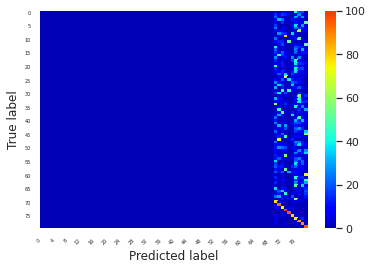

step: 8 classes: 90

Epoch 1/70
----------
Loss: 0.0421 Acc: 0.2764

Epoch 2/70
----------
Loss: 0.0218 Acc: 0.5638

Epoch 3/70
----------
Loss: 0.0179 Acc: 0.6720

Epoch 4/70
----------
Loss: 0.0152 Acc: 0.7216

Epoch 5/70
----------
Loss: 0.0128 Acc: 0.7786

Epoch 6/70
----------
Loss: 0.0116 Acc: 0.8032

Epoch 7/70
----------
Loss: 0.0100 Acc: 0.8346

Epoch 8/70
----------
Loss: 0.0099 Acc: 0.8316

Epoch 9/70
----------
Loss: 0.0094 Acc: 0.8432

Epoch 10/70
----------
Loss: 0.0089 Acc: 0.8510

Epoch 11/70
----------
Loss: 0.0077 Acc: 0.8760

Epoch 12/70
----------
Loss: 0.0076 Acc: 0.8764

Epoch 13/70
----------
Loss: 0.0073 Acc: 0.8828

Epoch 14/70
----------
Loss: 0.0077 Acc: 0.8716

Epoch 15/70
----------
Loss: 0.0076 Acc: 0.8764

Epoch 16/70
----------
Loss: 0.0064 Acc: 0.8974

Epoch 17/70
----------
Loss: 0.0066 Acc: 0.8914

Epoch 18/70
----------
Loss: 0.0052 Acc: 0.9192

Epoch 19/70
----------
Loss: 0.0050 Acc: 0.9244

Epoch 20/70
----------
Loss: 0.0050 Acc: 0.9178

Epoch 21

  0%|          | 0/71 [00:00<?, ?it/s]

Loss: 0.0002 Acc: 1.0000

Training complete in 6m 15s


100%|██████████| 71/71 [00:03<00:00, 18.54it/s]


Test Accuracy: 0.09644444444444444


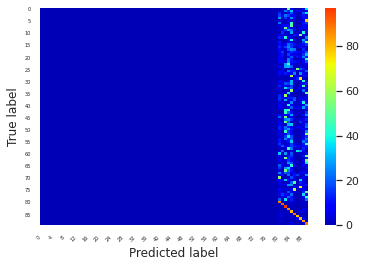

step: 0 classes: 10

Epoch 1/70
----------
Loss: 0.4350 Acc: 0.1240

Epoch 2/70
----------
Loss: 0.3183 Acc: 0.1508

Epoch 3/70
----------
Loss: 0.3073 Acc: 0.1986

Epoch 4/70
----------
Loss: 0.2991 Acc: 0.2222

Epoch 5/70
----------
Loss: 0.2971 Acc: 0.2364

Epoch 6/70
----------
Loss: 0.2929 Acc: 0.2470

Epoch 7/70
----------
Loss: 0.2908 Acc: 0.2560

Epoch 8/70
----------
Loss: 0.2869 Acc: 0.2760

Epoch 9/70
----------
Loss: 0.2836 Acc: 0.2916

Epoch 10/70
----------
Loss: 0.2810 Acc: 0.3074

Epoch 11/70
----------
Loss: 0.2709 Acc: 0.3382

Epoch 12/70
----------
Loss: 0.2621 Acc: 0.3688

Epoch 13/70
----------
Loss: 0.2541 Acc: 0.3934

Epoch 14/70
----------
Loss: 0.2521 Acc: 0.4012

Epoch 15/70
----------
Loss: 0.2473 Acc: 0.4172

Epoch 16/70
----------
Loss: 0.2415 Acc: 0.4280

Epoch 17/70
----------
Loss: 0.2358 Acc: 0.4480

Epoch 18/70
----------
Loss: 0.2329 Acc: 0.4610

Epoch 19/70
----------
Loss: 0.2259 Acc: 0.4842

Epoch 20/70
----------
Loss: 0.2216 Acc: 0.5018

Epoch 21

  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.0315 Acc: 0.9456

Training complete in 6m 15s


100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


Test Accuracy: 0.797


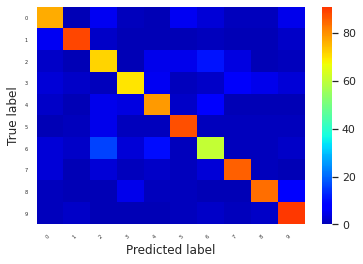

step: 1 classes: 20

Epoch 1/70
----------
Loss: 0.1703 Acc: 0.2904

Epoch 2/70
----------
Loss: 0.1076 Acc: 0.5178

Epoch 3/70
----------
Loss: 0.0892 Acc: 0.6198

Epoch 4/70
----------
Loss: 0.0793 Acc: 0.6714

Epoch 5/70
----------
Loss: 0.0708 Acc: 0.7080

Epoch 6/70
----------
Loss: 0.0637 Acc: 0.7352

Epoch 7/70
----------
Loss: 0.0614 Acc: 0.7566

Epoch 8/70
----------
Loss: 0.0550 Acc: 0.7804

Epoch 9/70
----------
Loss: 0.0529 Acc: 0.7922

Epoch 10/70
----------
Loss: 0.0498 Acc: 0.8056

Epoch 11/70
----------
Loss: 0.0460 Acc: 0.8220

Epoch 12/70
----------
Loss: 0.0453 Acc: 0.8204

Epoch 13/70
----------
Loss: 0.0429 Acc: 0.8338

Epoch 14/70
----------
Loss: 0.0439 Acc: 0.8288

Epoch 15/70
----------
Loss: 0.0405 Acc: 0.8476

Epoch 16/70
----------
Loss: 0.0392 Acc: 0.8474

Epoch 17/70
----------
Loss: 0.0345 Acc: 0.8716

Epoch 18/70
----------
Loss: 0.0346 Acc: 0.8702

Epoch 19/70
----------
Loss: 0.0348 Acc: 0.8720

Epoch 20/70
----------
Loss: 0.0311 Acc: 0.8828

Epoch 21

  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 0.0014 Acc: 0.9980

Training complete in 6m 16s


100%|██████████| 16/16 [00:01<00:00, 14.40it/s]


Test Accuracy: 0.4385


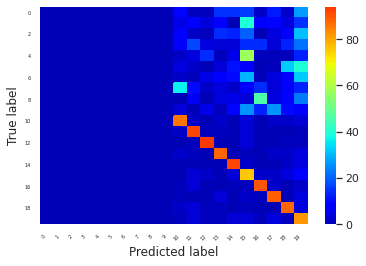

step: 2 classes: 30

Epoch 1/70
----------
Loss: 0.1134 Acc: 0.3156

Epoch 2/70
----------
Loss: 0.0641 Acc: 0.5654

Epoch 3/70
----------
Loss: 0.0535 Acc: 0.6540

Epoch 4/70
----------
Loss: 0.0464 Acc: 0.7028

Epoch 5/70
----------
Loss: 0.0426 Acc: 0.7320

Epoch 6/70
----------
Loss: 0.0386 Acc: 0.7616

Epoch 7/70
----------
Loss: 0.0369 Acc: 0.7704

Epoch 8/70
----------
Loss: 0.0332 Acc: 0.7960

Epoch 9/70
----------
Loss: 0.0317 Acc: 0.8036

Epoch 10/70
----------
Loss: 0.0292 Acc: 0.8256

Epoch 11/70
----------
Loss: 0.0268 Acc: 0.8376

Epoch 12/70
----------
Loss: 0.0280 Acc: 0.8370

Epoch 13/70
----------
Loss: 0.0259 Acc: 0.8416

Epoch 14/70
----------
Loss: 0.0239 Acc: 0.8602

Epoch 15/70
----------
Loss: 0.0227 Acc: 0.8648

Epoch 16/70
----------
Loss: 0.0258 Acc: 0.8464

Epoch 17/70
----------
Loss: 0.0221 Acc: 0.8748

Epoch 18/70
----------
Loss: 0.0227 Acc: 0.8736

Epoch 19/70
----------
Loss: 0.0197 Acc: 0.8896

Epoch 20/70
----------
Loss: 0.0193 Acc: 0.8946

Epoch 21

  0%|          | 0/24 [00:00<?, ?it/s]

Loss: 0.0009 Acc: 0.9984

Training complete in 6m 15s


100%|██████████| 24/24 [00:01<00:00, 16.39it/s]


Test Accuracy: 0.286


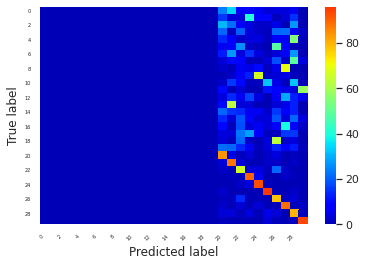

step: 3 classes: 40

Epoch 1/70
----------
Loss: 0.0847 Acc: 0.3124

Epoch 2/70
----------
Loss: 0.0469 Acc: 0.6118

Epoch 3/70
----------
Loss: 0.0359 Acc: 0.7210

Epoch 4/70
----------
Loss: 0.0300 Acc: 0.7746

Epoch 5/70
----------
Loss: 0.0255 Acc: 0.8128

Epoch 6/70
----------
Loss: 0.0230 Acc: 0.8354

Epoch 7/70
----------
Loss: 0.0213 Acc: 0.8444

Epoch 8/70
----------
Loss: 0.0189 Acc: 0.8664

Epoch 9/70
----------
Loss: 0.0182 Acc: 0.8676

Epoch 10/70
----------
Loss: 0.0161 Acc: 0.8850

Epoch 11/70
----------
Loss: 0.0145 Acc: 0.8962

Epoch 12/70
----------
Loss: 0.0134 Acc: 0.9080

Epoch 13/70
----------
Loss: 0.0126 Acc: 0.9134

Epoch 14/70
----------
Loss: 0.0121 Acc: 0.9130

Epoch 15/70
----------
Loss: 0.0112 Acc: 0.9240

Epoch 16/70
----------
Loss: 0.0102 Acc: 0.9320

Epoch 17/70
----------
Loss: 0.0095 Acc: 0.9362

Epoch 18/70
----------
Loss: 0.0095 Acc: 0.9366

Epoch 19/70
----------
Loss: 0.0091 Acc: 0.9382

Epoch 20/70
----------
Loss: 0.0119 Acc: 0.9172

Epoch 21

  0%|          | 0/32 [00:00<?, ?it/s]

Loss: 0.0004 Acc: 0.9998

Training complete in 6m 16s


100%|██████████| 32/32 [00:01<00:00, 17.16it/s]


Test Accuracy: 0.224


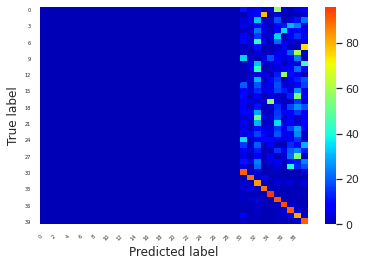

step: 4 classes: 50

Epoch 1/70
----------
Loss: 0.0668 Acc: 0.3326

Epoch 2/70
----------
Loss: 0.0307 Acc: 0.6824

Epoch 3/70
----------
Loss: 0.0230 Acc: 0.7772

Epoch 4/70
----------
Loss: 0.0195 Acc: 0.8118

Epoch 5/70
----------
Loss: 0.0177 Acc: 0.8340

Epoch 6/70
----------
Loss: 0.0157 Acc: 0.8550

Epoch 7/70
----------
Loss: 0.0140 Acc: 0.8710

Epoch 8/70
----------
Loss: 0.0138 Acc: 0.8732

Epoch 9/70
----------
Loss: 0.0124 Acc: 0.8886

Epoch 10/70
----------
Loss: 0.0119 Acc: 0.8896

Epoch 11/70
----------
Loss: 0.0135 Acc: 0.8684

Epoch 12/70
----------
Loss: 0.0107 Acc: 0.9024

Epoch 13/70
----------
Loss: 0.0099 Acc: 0.9122

Epoch 14/70
----------
Loss: 0.0095 Acc: 0.9144

Epoch 15/70
----------
Loss: 0.0090 Acc: 0.9182

Epoch 16/70
----------
Loss: 0.0093 Acc: 0.9178

Epoch 17/70
----------
Loss: 0.0079 Acc: 0.9298

Epoch 18/70
----------
Loss: 0.0085 Acc: 0.9236

Epoch 19/70
----------
Loss: 0.0077 Acc: 0.9336

Epoch 20/70
----------
Loss: 0.0077 Acc: 0.9332

Epoch 21

  0%|          | 0/40 [00:00<?, ?it/s]

Loss: 0.0004 Acc: 0.9998

Training complete in 6m 15s


100%|██████████| 40/40 [00:02<00:00, 17.38it/s]


Test Accuracy: 0.177


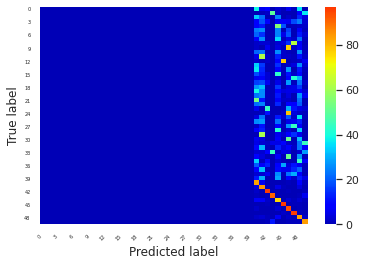

step: 5 classes: 60

Epoch 1/70
----------
Loss: 0.0594 Acc: 0.3062

Epoch 2/70
----------
Loss: 0.0298 Acc: 0.6284

Epoch 3/70
----------
Loss: 0.0232 Acc: 0.7230

Epoch 4/70
----------
Loss: 0.0193 Acc: 0.7792

Epoch 5/70
----------
Loss: 0.0166 Acc: 0.8106

Epoch 6/70
----------
Loss: 0.0147 Acc: 0.8362

Epoch 7/70
----------
Loss: 0.0136 Acc: 0.8510

Epoch 8/70
----------
Loss: 0.0124 Acc: 0.8650

Epoch 9/70
----------
Loss: 0.0114 Acc: 0.8736

Epoch 10/70
----------
Loss: 0.0098 Acc: 0.8928

Epoch 11/70
----------
Loss: 0.0096 Acc: 0.9010

Epoch 12/70
----------
Loss: 0.0091 Acc: 0.9036

Epoch 13/70
----------
Loss: 0.0086 Acc: 0.9078

Epoch 14/70
----------
Loss: 0.0083 Acc: 0.9128

Epoch 15/70
----------
Loss: 0.0105 Acc: 0.8792

Epoch 16/70
----------
Loss: 0.0095 Acc: 0.9014

Epoch 17/70
----------
Loss: 0.0080 Acc: 0.9138

Epoch 18/70
----------
Loss: 0.0074 Acc: 0.9262

Epoch 19/70
----------
Loss: 0.0089 Acc: 0.9060

Epoch 20/70
----------
Loss: 0.0070 Acc: 0.9260

Epoch 21

  0%|          | 0/47 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9990

Training complete in 6m 16s


100%|██████████| 47/47 [00:02<00:00, 17.80it/s]


Test Accuracy: 0.1465


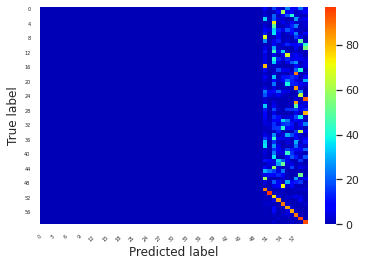

step: 6 classes: 70

Epoch 1/70
----------
Loss: 0.0504 Acc: 0.3136

Epoch 2/70
----------
Loss: 0.0264 Acc: 0.6016

Epoch 3/70
----------
Loss: 0.0213 Acc: 0.6972

Epoch 4/70
----------
Loss: 0.0182 Acc: 0.7396

Epoch 5/70
----------
Loss: 0.0164 Acc: 0.7746

Epoch 6/70
----------
Loss: 0.0150 Acc: 0.7964

Epoch 7/70
----------
Loss: 0.0136 Acc: 0.8134

Epoch 8/70
----------
Loss: 0.0134 Acc: 0.8178

Epoch 9/70
----------
Loss: 0.0129 Acc: 0.8308

Epoch 10/70
----------
Loss: 0.0111 Acc: 0.8476

Epoch 11/70
----------
Loss: 0.0099 Acc: 0.8684

Epoch 12/70
----------
Loss: 0.0101 Acc: 0.8662

Epoch 13/70
----------
Loss: 0.0099 Acc: 0.8722

Epoch 14/70
----------
Loss: 0.0085 Acc: 0.8912

Epoch 15/70
----------
Loss: 0.0084 Acc: 0.8918

Epoch 16/70
----------
Loss: 0.0082 Acc: 0.8936

Epoch 17/70
----------
Loss: 0.0083 Acc: 0.8948

Epoch 18/70
----------
Loss: 0.0074 Acc: 0.9058

Epoch 19/70
----------
Loss: 0.0077 Acc: 0.9042

Epoch 20/70
----------
Loss: 0.0072 Acc: 0.9106

Epoch 21

  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9996

Training complete in 6m 13s


100%|██████████| 55/55 [00:03<00:00, 18.23it/s]


Test Accuracy: 0.12428571428571429


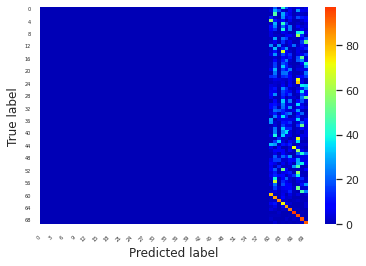

step: 7 classes: 80

Epoch 1/70
----------
Loss: 0.0422 Acc: 0.3148

Epoch 2/70
----------
Loss: 0.0225 Acc: 0.5958

Epoch 3/70
----------
Loss: 0.0180 Acc: 0.6988

Epoch 4/70
----------
Loss: 0.0162 Acc: 0.7388

Epoch 5/70
----------
Loss: 0.0139 Acc: 0.7766

Epoch 6/70
----------
Loss: 0.0125 Acc: 0.8128

Epoch 7/70
----------
Loss: 0.0111 Acc: 0.8262

Epoch 8/70
----------
Loss: 0.0103 Acc: 0.8442

Epoch 9/70
----------
Loss: 0.0106 Acc: 0.8388

Epoch 10/70
----------
Loss: 0.0089 Acc: 0.8656

Epoch 11/70
----------
Loss: 0.0086 Acc: 0.8704

Epoch 12/70
----------
Loss: 0.0082 Acc: 0.8794

Epoch 13/70
----------
Loss: 0.0076 Acc: 0.8914

Epoch 14/70
----------
Loss: 0.0087 Acc: 0.8716

Epoch 15/70
----------
Loss: 0.0075 Acc: 0.8930

Epoch 16/70
----------
Loss: 0.0066 Acc: 0.9008

Epoch 17/70
----------
Loss: 0.0070 Acc: 0.8996

Epoch 18/70
----------
Loss: 0.0064 Acc: 0.9082

Epoch 19/70
----------
Loss: 0.0055 Acc: 0.9270

Epoch 20/70
----------
Loss: 0.0051 Acc: 0.9264

Epoch 21

  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9990

Training complete in 6m 15s


100%|██████████| 63/63 [00:03<00:00, 18.26it/s]


Test Accuracy: 0.111


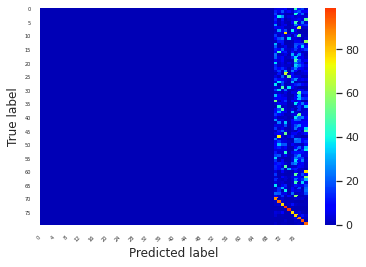

step: 8 classes: 90

Epoch 1/70
----------
Loss: 0.0381 Acc: 0.3106

Epoch 2/70
----------
Loss: 0.0221 Acc: 0.5450

Epoch 3/70
----------
Loss: 0.0178 Acc: 0.6674

Epoch 4/70
----------
Loss: 0.0152 Acc: 0.7356

Epoch 5/70
----------
Loss: 0.0137 Acc: 0.7518

Epoch 6/70
----------
Loss: 0.0122 Acc: 0.7886

Epoch 7/70
----------
Loss: 0.0108 Acc: 0.8158

Epoch 8/70
----------
Loss: 0.0101 Acc: 0.8262

Epoch 9/70
----------
Loss: 0.0093 Acc: 0.8416

Epoch 10/70
----------
Loss: 0.0099 Acc: 0.8308

Epoch 11/70
----------
Loss: 0.0089 Acc: 0.8456

Epoch 12/70
----------
Loss: 0.0085 Acc: 0.8536

Epoch 13/70
----------
Loss: 0.0084 Acc: 0.8612

Epoch 14/70
----------
Loss: 0.0071 Acc: 0.8808

Epoch 15/70
----------
Loss: 0.0070 Acc: 0.8854

Epoch 16/70
----------
Loss: 0.0067 Acc: 0.8922

Epoch 17/70
----------
Loss: 0.0061 Acc: 0.9010

Epoch 18/70
----------
Loss: 0.0058 Acc: 0.9096

Epoch 19/70
----------
Loss: 0.0064 Acc: 0.8934

Epoch 20/70
----------
Loss: 0.0052 Acc: 0.9174

Epoch 21

  0%|          | 0/71 [00:00<?, ?it/s]

Loss: 0.0003 Acc: 0.9988

Training complete in 6m 15s


100%|██████████| 71/71 [00:03<00:00, 18.47it/s]


Test Accuracy: 0.099


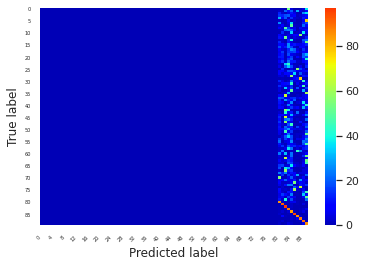

step: 0 classes: 10

Epoch 1/70
----------
Loss: 0.3917 Acc: 0.1284

Epoch 2/70
----------
Loss: 0.3176 Acc: 0.1508

Epoch 3/70
----------
Loss: 0.3127 Acc: 0.1610

Epoch 4/70
----------
Loss: 0.3117 Acc: 0.1676

Epoch 5/70
----------
Loss: 0.3112 Acc: 0.1616

Epoch 6/70
----------
Loss: 0.3107 Acc: 0.1720

Epoch 7/70
----------
Loss: 0.3097 Acc: 0.1762

Epoch 8/70
----------
Loss: 0.3082 Acc: 0.1854

Epoch 9/70
----------
Loss: 0.3066 Acc: 0.1918

Epoch 10/70
----------
Loss: 0.3041 Acc: 0.2104

Epoch 11/70
----------
Loss: 0.2980 Acc: 0.2396

Epoch 12/70
----------
Loss: 0.2915 Acc: 0.2696

Epoch 13/70
----------
Loss: 0.2817 Acc: 0.3040

Epoch 14/70
----------
Loss: 0.2746 Acc: 0.3286

Epoch 15/70
----------
Loss: 0.2673 Acc: 0.3558

Epoch 16/70
----------
Loss: 0.2588 Acc: 0.3840

Epoch 17/70
----------
Loss: 0.2515 Acc: 0.4126

Epoch 18/70
----------
Loss: 0.2412 Acc: 0.4482

Epoch 19/70
----------
Loss: 0.2351 Acc: 0.4672

Epoch 20/70
----------
Loss: 0.2276 Acc: 0.4922

Epoch 21

  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.0202 Acc: 0.9726

Training complete in 6m 14s


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Test Accuracy: 0.81


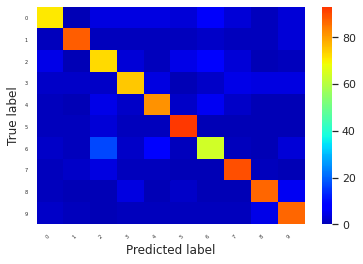

step: 1 classes: 20

Epoch 1/70
----------
Loss: 0.1648 Acc: 0.3184

Epoch 2/70
----------
Loss: 0.0992 Acc: 0.5716

Epoch 3/70
----------
Loss: 0.0819 Acc: 0.6572

Epoch 4/70
----------
Loss: 0.0697 Acc: 0.7176

Epoch 5/70
----------
Loss: 0.0647 Acc: 0.7388

Epoch 6/70
----------
Loss: 0.0593 Acc: 0.7654

Epoch 7/70
----------
Loss: 0.0540 Acc: 0.7940

Epoch 8/70
----------
Loss: 0.0533 Acc: 0.7920

Epoch 9/70
----------
Loss: 0.0481 Acc: 0.8178

Epoch 10/70
----------
Loss: 0.0453 Acc: 0.8226

Epoch 11/70
----------
Loss: 0.0409 Acc: 0.8452

Epoch 12/70
----------
Loss: 0.0395 Acc: 0.8576

Epoch 13/70
----------
Loss: 0.0368 Acc: 0.8606

Epoch 14/70
----------
Loss: 0.0343 Acc: 0.8712

Epoch 15/70
----------
Loss: 0.0345 Acc: 0.8716

Epoch 16/70
----------
Loss: 0.0319 Acc: 0.8804

Epoch 17/70
----------
Loss: 0.0318 Acc: 0.8792

Epoch 18/70
----------
Loss: 0.0283 Acc: 0.8960

Epoch 19/70
----------
Loss: 0.0286 Acc: 0.8974

Epoch 20/70
----------
Loss: 0.0291 Acc: 0.8880

Epoch 21

  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 0.0010 Acc: 0.9992

Training complete in 6m 12s


100%|██████████| 16/16 [00:01<00:00, 15.43it/s]


Test Accuracy: 0.4435


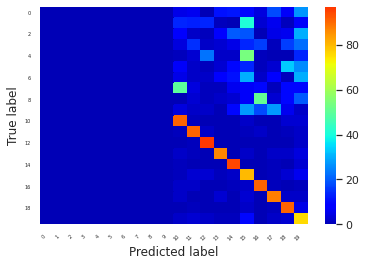

step: 2 classes: 30

Epoch 1/70
----------
Loss: 0.1217 Acc: 0.3040

Epoch 2/70
----------
Loss: 0.0627 Acc: 0.5704

Epoch 3/70
----------
Loss: 0.0528 Acc: 0.6498

Epoch 4/70
----------
Loss: 0.0457 Acc: 0.7026

Epoch 5/70
----------
Loss: 0.0419 Acc: 0.7222

Epoch 6/70
----------
Loss: 0.0369 Acc: 0.7642

Epoch 7/70
----------
Loss: 0.0330 Acc: 0.7904

Epoch 8/70
----------
Loss: 0.0313 Acc: 0.8028

Epoch 9/70
----------
Loss: 0.0295 Acc: 0.8136

Epoch 10/70
----------
Loss: 0.0286 Acc: 0.8244

Epoch 11/70
----------
Loss: 0.0259 Acc: 0.8418

Epoch 12/70
----------
Loss: 0.0258 Acc: 0.8474

Epoch 13/70
----------
Loss: 0.0252 Acc: 0.8468

Epoch 14/70
----------
Loss: 0.0232 Acc: 0.8618

Epoch 15/70
----------
Loss: 0.0204 Acc: 0.8846

Epoch 16/70
----------
Loss: 0.0194 Acc: 0.8906

Epoch 17/70
----------
Loss: 0.0183 Acc: 0.8946

Epoch 18/70
----------
Loss: 0.0170 Acc: 0.9062

Epoch 19/70
----------
Loss: 0.0180 Acc: 0.8968

Epoch 20/70
----------
Loss: 0.0167 Acc: 0.9024

Epoch 21

  0%|          | 0/24 [00:00<?, ?it/s]

Loss: 0.0008 Acc: 0.9996

Training complete in 6m 11s


100%|██████████| 24/24 [00:01<00:00, 16.57it/s]


Test Accuracy: 0.2896666666666667


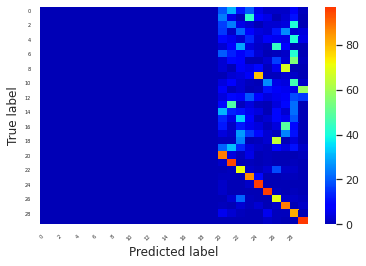

step: 3 classes: 40

Epoch 1/70
----------
Loss: 0.0871 Acc: 0.3370

Epoch 2/70
----------
Loss: 0.0414 Acc: 0.6644

Epoch 3/70
----------
Loss: 0.0304 Acc: 0.7650

Epoch 4/70
----------
Loss: 0.0253 Acc: 0.8130

Epoch 5/70
----------
Loss: 0.0215 Acc: 0.8378

Epoch 6/70
----------
Loss: 0.0183 Acc: 0.8680

Epoch 7/70
----------
Loss: 0.0167 Acc: 0.8836

Epoch 8/70
----------
Loss: 0.0142 Acc: 0.9034

Epoch 9/70
----------
Loss: 0.0132 Acc: 0.9096

Epoch 10/70
----------
Loss: 0.0140 Acc: 0.9020

Epoch 11/70
----------
Loss: 0.0113 Acc: 0.9264

Epoch 12/70
----------
Loss: 0.0121 Acc: 0.9190

Epoch 13/70
----------
Loss: 0.0110 Acc: 0.9254

Epoch 14/70
----------
Loss: 0.0096 Acc: 0.9364

Epoch 15/70
----------
Loss: 0.0099 Acc: 0.9350

Epoch 16/70
----------
Loss: 0.0081 Acc: 0.9472

Epoch 17/70
----------
Loss: 0.0077 Acc: 0.9518

Epoch 18/70
----------
Loss: 0.0068 Acc: 0.9558

Epoch 19/70
----------
Loss: 0.0068 Acc: 0.9568

Epoch 20/70
----------
Loss: 0.0066 Acc: 0.9574

Epoch 21

In [ ]:
cum_acc = np.zeros((10,3))
runs = 3
for run in range(runs):
    finetuning = FineTuning(10, d)
    for i,idx in enumerate(range(10,100,10)):
        print(f'step: {i} classes: {idx}')
        print()
        finetuning.train_model(train_dataloaders[i])
        acc = finetuning.test_model(test_dataloaders[i])
        finetuning.update_model()
        finetuning.num_classes = idx+10
        cum_acc[i, run] = acc

In [76]:
cum_acc

array([[0.134     , 0.174     , 0.139     ],
       [0.064     , 0.0915    , 0.092     ],
       [0.04033333, 0.04833333, 0.06233333],
       [0.02725   , 0.038     , 0.039     ],
       [0.0244    , 0.0278    , 0.025     ],
       [0.01766667, 0.03016667, 0.02633333],
       [0.02185714, 0.02714286, 0.02171429],
       [0.01875   , 0.032     , 0.018375  ],
       [0.01466667, 0.02266667, 0.01777778],
       [0.        , 0.        , 0.        ]])

<Figure size 432x288 with 0 Axes>

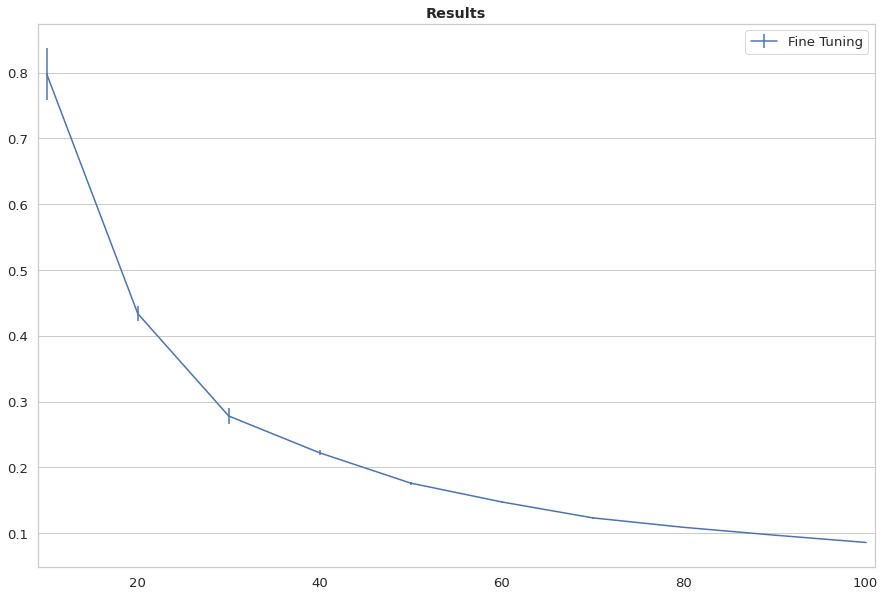

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
import pandas as pd
sns.set()
r = np.random.rand(10,3)
means = np.mean(r, axis=1)
std = np.std(r, axis=1)
# cum_acc_lwf = np.random.rand(10,3)
cum_acc_fin = cum_acc
# cum_acc_icarl = np.random.rand(10,3)


sns.set(font_scale=1.2)
sns.set_style("whitegrid")

x = np.arange(10,110,10)
# y1 = np.mean(cum_acc_lwf, axis =1)
# err1 = np.std(cum_acc_lwf, axis = 1)
# print(err1, y1)
y2 = np.mean(cum_acc_fin, axis =1)
err2 = np.std(cum_acc_fin, axis = 1) 

# y3 = np.mean(cum_acc_icarl, axis =1)
# err3 = np.std(cum_acc_icarl, axis = 1)

fig, ax = plt.subplots(figsize = (15,10),)
ax.set_title('Results', fontweight = 'bold')
# ax.errorbar(x , y1, yerr=err1, label = 'Fine Tuning')
ax.errorbar(x , y2, yerr=err2, label = 'Fine Tuning')
# ax.errorbar(x , y3, yerr=err3, label = 'iCaRL')

ax.legend()
ax.set_xlim(min(x)-1, max(x)+1)
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines
plt.figure()

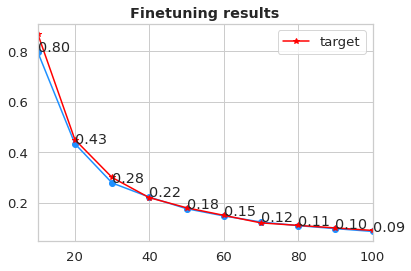

<Figure size 432x288 with 0 Axes>

In [ ]:
true_ = [0.87, 0.45, 0.30, 0.22, 0.18, 0.15, 0.12, 0.11, 0.10, 0.09]
x = np.arange(10,110,10)
y = np.mean(cum_acc, axis = 1)
# plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.set_title('Finetuning results', fontweight = 'bold')
ax.plot(x, y, '-o', color = 'dodgerblue')
ax.plot(x, true_, '-*', color = 'red', label = 'target')
ax.grid(b = True)
ax.legend()
ax.set_xlim(min(x), max(x))
plt.figure()


for i, txt in enumerate(y):
  ax.annotate("{:.2f}".format(txt), (x[i], y[i]))